In [3]:
import pydicom
import matplotlib.pyplot as plt

import os
import numpy as np
import vtk
from vtk.util.numpy_support import numpy_to_vtk

In [ ]:
# Загрузка DICOM-файла
dcm_path = "files_dcm/0372.dcm"
dicom_data = pydicom.dcmread(dcm_path)

# Получение массива пикселей
image = dicom_data.pixel_array

# Отображение изображения
plt.imshow(image, cmap="gray")  # DICOM обычно в градациях серого
plt.axis("off")  # Отключаем оси для удобства
plt.show()

In [ ]:
# Загружаем DICOM-файл
dcm_path_true = "files_dcm/0344.dcm"
dcm_path = "files_dcm/0372.dcm"
dicom_data = pydicom.dcmread(dcm_path)

if 'PixelRepresentation' not in dicom_data:
    dicom_data.PixelRepresentation = 1

# Получаем пиксельные данные
image = dicom_data.pixel_array.astype(np.int16)

# Корректируем HU
intercept = dicom_data.RescaleIntercept if "RescaleIntercept" in dicom_data else 0
slope = dicom_data.RescaleSlope if "RescaleSlope" in dicom_data else 1
hu_image = image * slope + intercept

# Определяем категории HU
air_mask = (hu_image <= -500)  # Воздух (не учитываем в гистограмме)
soft_tissue_mask = (hu_image > -500) & (hu_image < 300)  # Мягкие ткани
soft_bone_mask = (hu_image >= 300) & (hu_image < 700)  # Мягкая кость
hard_bone_mask = (hu_image >= 700) & (hu_image < 1200)  # Твёрдая кость
very_hard_bone_mask = (hu_image >= 1200)  # Очень плотная кость (зубы)

# Подсчитываем количество пикселей в каждой категории
counts = [
    np.sum(soft_tissue_mask), 
    np.sum(soft_bone_mask), 
    np.sum(hard_bone_mask), 
    np.sum(very_hard_bone_mask)
]

labels = ["Мягкие ткани", "Мягкая кость", "Твёрдая кость", "Очень плотная кость (зубы)"]
colors = ["blue", "green", "red", "purple"]

# Создаём цветное изображение
colored_image = np.zeros((*hu_image.shape, 3), dtype=np.uint8)
colored_image[air_mask] = [255, 255, 255]  # Фон
colored_image[soft_tissue_mask] = [0, 0, 255]  # Синий (мягкие ткани)
colored_image[soft_bone_mask] = [0, 255, 0]  # Зеленый (мягкая кость)
colored_image[hard_bone_mask] = [255, 0, 0]  # Красный (твёрдая кость)
colored_image[very_hard_bone_mask] = [128, 0, 128]  # Фиолетовый (очень плотная кость)

# Построение графиков
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Круговая диаграмма (без воздуха)
axes[0].pie(counts, labels=labels, autopct="%1.1f%%", colors=colors, startangle=90, wedgeprops={"edgecolor": "black"})
axes[0].set_title("Распределение плотностей (HU) (без воздуха)")

# Цветное DICOM-изображение
axes[1].imshow(colored_image)
axes[1].set_title("DICOM с градацией костей (без воздуха)")
axes[1].axis("off")  # Отключаем оси

# Гистограмма HU (без воздуха)
hu_image_no_air = hu_image[~air_mask]  # Убираем воздух из массива данных
axes[2].hist(hu_image_no_air.flatten(), bins=1000, color="blue", alpha=0.7, range=(-1000, 2000))
axes[2].set_title("Гистограмма распределения HU (без воздуха)")
axes[2].set_xlabel("HU")
axes[2].set_ylabel("Количество пикселей")
axes[2].grid(True)

plt.tight_layout()
# fig.savefig("output_graphics.svg", format='svg')
plt.show()

In [ ]:
dcm_dir = "files_dcm"

# Загружаем файлы
files = [pydicom.dcmread(os.path.join(dcm_dir, f)) for f in os.listdir(dcm_dir) if f.endswith(".dcm")]
files.sort(key=lambda x: int(x.InstanceNumber))

# Создаём 3D-массив
volume = np.stack([f.pixel_array for f in files])

# Преобразуем в VTK-объект
data = vtk.vtkImageData()
data.SetDimensions(volume.shape)
data.SetSpacing(1, 1, 1)
data.AllocateScalars(vtk.VTK_FLOAT, 1)
vtk_array = numpy_to_vtk(volume.ravel(), deep=True)
data.GetPointData().SetScalars(vtk_array)

# Создаём рендер
renderer = vtk.vtkRenderer()
actor = vtk.vtkVolume()
mapper = vtk.vtkSmartVolumeMapper()
mapper.SetInputData(data)
actor.SetMapper(mapper)
renderer.AddViewProp(actor)

# Окно
render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(render_window)

# Запуск
render_window.Render()
interactor.Start()

In [ ]:
def visualize_tensor(tensor, title="Tensor Image", cmap='gray'):
    # Проверяем, является ли тензор 3D
    if tensor.ndimension() == 3:
        # Переводим в формат (H, W, C) для отображения с помощью matplotlib
        tensor = tensor.permute(1, 2, 0)

    # Преобразуем тензор в numpy для отображения
    np_image = tensor.cpu().numpy()

    # В случае черно-белого изображения (если у нас один канал), покажем через cmap
    if np_image.shape[2] == 1:
        np_image = np_image[:, :, 0]

    # Отображаем изображение
    plt.imshow(np_image, cmap=cmap)
    plt.title(title)
    plt.axis('off')  # Скрыть оси
    plt.show()


In [4]:
import pandas as pd

# Пути к загруженным файлам
file_potology = "Table-potology.csv"
file_standard = "Table-standard.csv"

# Загрузка данных
df_potology = pd.read_csv(file_potology)
df_standard = pd.read_csv(file_standard)

# Проверим размеры и первые строки данных
df_potology.shape, df_standard.shape

((129, 4), (129, 4))

In [5]:
# Переименуем последний столбец в df_false, чтобы он совпадал с df_true
df_potology.rename(columns={df_potology.columns[-1]: "Segmentation_segment_head"}, inplace=True)

# Объединим два датафрейма для удобного сравнения
df_merged = df_potology.merge(df_standard, on=["Image type", "Feature Class", "Feature Name"], suffixes=("_potology", "_standard"))

# Найдем строки, где значения отличаются
df_diff = df_merged[df_merged["Segmentation_segment_head_potology"] != df_merged["Segmentation_segment_head_standard"]]

# Выведем количество отличий и примеры
df_diff.shape[0], df_diff.head()

(119,
      Image type   Feature Class Feature Name  \
 7   diagnostics  Image-original         Hash   
 9   diagnostics  Image-original      Spacing   
 10  diagnostics  Image-original         Size   
 11  diagnostics  Image-original         Mean   
 13  diagnostics  Image-original      Maximum   
 
           Segmentation_segment_head_potology  \
 7   1a607fc775d06fae38e5510d647dc44172215d12   
 9                            (0.2, 0.2, 0.2)   
 10                        (1003, 1003, 1003)   
 11                        -558.4072434057805   
 13                                    3095.0   
 
                    Segmentation_segment_head_standard  
 7            c6006e7bc4eb8057b1022f8d4854e57b1a0d64ed  
 9   (0.30000000000000004, 0.30000000000000004, 0.3...  
 10                                    (768, 768, 576)  
 11                                 -757.5032671498664  
 13                                            13056.0  )

In [6]:
# Преобразуем числовые значения в последнем столбце к float (где возможно)
def try_convert(value):
    try:
        return float(value)
    except:
        return np.nan  # если не число, заменяем NaN

df_diff["potology_values"] = (df_diff["Segmentation_segment_head_potology"]
                           .apply(try_convert))
df_diff["standard_values"] = (df_diff["Segmentation_segment_head_standard"]
                          .apply(try_convert))

df_numeric = df_diff.dropna(subset=["potology_values", "standard_values"])

/var/folders/cs/dtsbgx152_5dvn59nv2l1dx80000gn/T/ipykernel_25701/736301444.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff["potology_values"] = (df_diff["Segmentation_segment_head_potology"]
/var/folders/cs/dtsbgx152_5dvn59nv2l1dx80000gn/T/ipykernel_25701/736301444.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff["standard_values"] = (df_diff["Segmentation_segment_head_standard"]


In [7]:
# Добавим новый столбец с абсолютной разницей (только для чисел)
df_numeric["abs_difference"] = abs(df_numeric["standard_values"] - df_numeric["potology_values"])

# Отсортируем по наибольшим различиям
df_numeric_sorted = df_numeric.sort_values(by="abs_difference", ascending=False)

# Выберем ключевые столбцы для вывода
df_display = df_numeric_sorted[
    [
        "Feature Name",
        "Segmentation_segment_head_standard",
        "Segmentation_segment_head_potology",
        "abs_difference"
    ]
]


/var/folders/cs/dtsbgx152_5dvn59nv2l1dx80000gn/T/ipykernel_25701/1320083640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric["abs_difference"] = abs(df_numeric["standard_values"] - df_numeric["potology_values"])


In [8]:
df_display.head(100)

,Feature Name,Segmentation_segment_head_standard,Segmentation_segment_head_potology,abs_difference
38,Energy,347305063854.0,1618130912889.0,1.270826e+12
51,TotalEnergy,9377236724.058004,12945047303.112003,3.567811e+09
113,LargeAreaHighGrayLevelEmphasis,1277799.3521061845,20918885.394256614,1.964109e+07
55,ClusterProminence,2087497.8236446003,5608665.668279499,3.521168e+06
18,VoxelNum,665915,1885915,1.220000e+06
...,...,...,...,...
103,RunPercentage,0.8983439212327284,0.8941214211669136,4.222500e-03
93,GrayLevelNonUniformityNormalized,0.018199424069342253,0.01489749513617991,3.301929e-03
52,Uniformity,0.017872703057358878,0.014943455444346325,2.929248e-03
65,Idmn,0.9946024970289961,0.9968971580563484,2.294661e-03


In [9]:
df_display.to_csv("differences.csv", index=False)

In [10]:
# Дополняем словарь переводов и определений
radiomics_translations = {
    "RunLengthNonUniformity": "Неоднородность длины пробега — мера вариативности длин последовательностей одинаковых значений",
    "DependenceNonUniformity": "Неоднородность зависимости — вариативность размеров зависимых областей",
    "Variance": "Дисперсия — среднеквадратичное отклонение интенсивностей",
    "SizeZoneNonUniformity": "Неоднородность размеров зон — вариативность размеров областей с одинаковыми значениями",
    "LargeDependenceHighGrayLevelEmphasis": "Выделение больших областей высокой интенсивности",
    "GrayLevelNonUniformity": "Неоднородность уровней серого — вариативность интенсивностей в изображении",
    "ClusterShade": "Кластерный оттенок — мера асимметрии текстурных кластеров",
    "Maximum": "Максимум — наибольшее значение интенсивности",
    "LargeAreaEmphasis": "Выделение больших областей — определяет значимость больших однородных зон",
    "ZoneVariance": "Дисперсия зон — изменчивость размеров областей",
    "MeshVolume": "Объём сетки — рассчитанный объём объекта на основе сеточной модели",
    "VoxelVolume": "Объём вокселей — суммарный объём вокселей в зоне интереса",
    "SurfaceArea": "Площадь поверхности — площадь границы сегментированной области",
    "LongRunHighGrayLevelEmphasis": "Выделение длинных последовательностей с высокой интенсивностью",
    "Complexity": "Сложность — мера сложности текстуры на основе различий между пикселями",
    "HighGrayLevelEmphasis": "Выделение высоких уровней серого — оценивает преобладание ярких областей",
    "HighGrayLevelRunEmphasis": "Выделение длинных ярких последовательностей пикселей",
    "Autocorrelation": "Автокорреляция — мера повторяемости интенсивностей в изображении",
    "HighGrayLevelZoneEmphasis": "Выделение ярких зон — оценивает вклад зон высокой интенсивности",
    "ShortRunHighGrayLevelEmphasis": "Выделение коротких последовательностей с высокой интенсивностью",
    "ClusterTendency": "Кластерная тенденция — склонность пикселей образовывать однородные кластеры",
    "SmallAreaHighGrayLevelEmphasis": "Выделение маленьких ярких областей",
    "90Percentile": "90-й перцентиль — значение интенсивности, ниже которого лежат 90% значений",
    "InterquartileRange": "Межквартильный размах — разница между 75-м и 25-м процентилями",
    "Range": "Диапазон — разница между максимальным и минимальным значением интенсивности",
    "RootMeanSquared": "Среднеквадратичное значение — мера общего уровня интенсивности",
    "SumSquares": "Сумма квадратов — мера разброса интенсивностей",
    "Mean": "Среднее значение интенсивности",
    "GrayLevelVariance": "Дисперсия уровней серого — изменчивость интенсивностей",
    "MeanAbsoluteDeviation": "Среднее абсолютное отклонение — среднее отклонение интенсивностей от среднего",
    "RobustMeanAbsoluteDeviation": "Устойчивое среднее абсолютное отклонение — аналог MAD, но устойчивый к выбросам",
    "Median": "Медиана — значение, делящее распределение интенсивностей пополам",
    "SmallDependenceHighGrayLevelEmphasis": "Выделение мелких зависимых областей высокой интенсивности",
    "Minimum": "Минимум — наименьшее значение интенсивности",
    "MajorAxisLength": "Длина главной оси — длина самой длинной оси эллипсоида, аппроксимирующего объект",
    "Maximum3DDiameter": "Максимальный 3D диаметр — наибольшее расстояние между точками объекта",
    "Maximum2DDiameterColumn": "Максимальный 2D диаметр (колонка) — наибольшая ширина объекта в одном измерении",
    "SumAverage": "Среднее суммы — характеристика совместного распределения интенсивностей",
    "Contrast": "Контраст — разница между соседними интенсивностями",
    "Maximum2DDiameterSlice": "Максимальный 2D диаметр (срез) — наибольший размер в пределах одного среза",
    "JointAverage": "Среднее совместного распределения интенсивностей",
    "10Percentile": "10-й перцентиль — значение, ниже которого 10% значений интенсивности",
    "Maximum2DDiameterRow": "Максимальный 2D диаметр (ряд) — ширина объекта по горизонтали",
    "Busyness": "Загруженность — мера локальной неоднородности интенсивностей",
    "DifferenceVariance": "Дисперсия разностей — мера вариативности разностей интенсивностей",
    "DependenceVariance": "Дисперсия зависимостей — мера вариативности областей зависимостей",
    "MinorAxisLength": "Длина малой оси — короткая ось эллипсоида, аппроксимирующего объект",
    "LargeDependenceEmphasis": "Выделение больших зависимых областей",
    "LargeAreaLowGrayLevelEmphasis": "Выделение больших тёмных областей",
    "LeastAxisLength": "Длина наименьшей оси — самая короткая ось 3D объекта",
    "ZoneEntropy": "Энтропия зон — мера случайности распределения зон",
    "DifferenceAverage": "Среднее разностей — мера отличий между соседними интенсивностями",
    "Kurtosis": "Куртозис — характеристика остроты распределения интенсивностей",
    "RunEntropy": "Энтропия пробегов — мера случайности последовательностей пикселей",
    "SurfaceVolumeRatio": "Отношение площади к объёму — показатель компактности формы",
    "Entropy": "Энтропия — мера случайности интенсивностей",
    "SumEntropy": "Суммарная энтропия — мера неоднородности совместного распределения",
    "DependenceEntropy": "Энтропия зависимостей — случайность распределения зависимых областей",
    "DifferenceEntropy": "Энтропия разностей — случайность распределения разностей интенсивностей",
    "Sphericity": "Сферичность — мера похожести объекта на сферу",
    "JointEntropy": "Совместная энтропия — мера случайности совместного распределения интенсивностей",
    "ZonePercentage": "Процент зон — доля областей относительно общего количества вокселей",
    "SmallDependenceEmphasis": "Выделение мелких зависимых областей",
    "Imc1": "Информация о корреляции 1 — мера зависимости между интенсивностями",
    "Strength": "Сила — характеристика текстурной структуры",
    "SizeZoneNonUniformityNormalized": "Нормализованная неоднородность размеров зон",
    "Correlation": "Корреляция — мера связи между интенсивностями соседних пикселей",
    "Skewness": "Асимметрия — мера сдвига распределения интенсивностей",
    "Elongation": "Удлинённость — степень вытянутости формы",
    "SmallAreaEmphasis": "Выделение мелких областей",
    "MCC": "Матчевый коэффициент корреляции",
    "Flatness": "Плоскостность — степень сплюснутости формы",
    "Imc2": "Информация о корреляции 2 — мера связи между интенсивностями",
}

# Заполняем пропущенные описания
df_display["Feature Description"] = df_display["Feature Name"].map(radiomics_translations).fillna("Нет данных")

# Сохраняем обновлённый файл
updated_file_path = "differences_full.csv"
df_display.to_csv(updated_file_path, index=False)

/var/folders/cs/dtsbgx152_5dvn59nv2l1dx80000gn/T/ipykernel_25701/3609893380.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_display["Feature Description"] = df_display["Feature Name"].map(radiomics_translations).fillna("Нет данных")


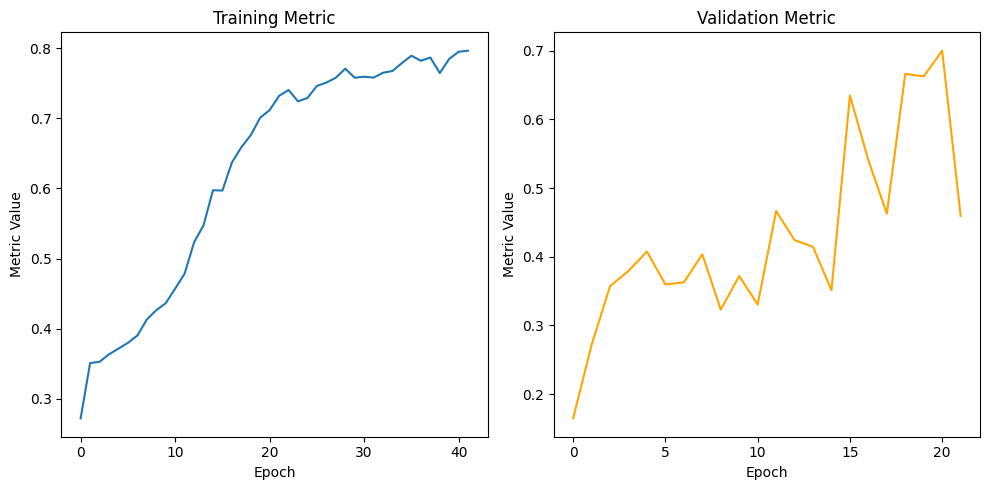

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO

# Данные для тренировки
train_data = """
Wall time,Step,Value
1741033853.789021,0,0.2721464931964874
1741033871.143897,1,0.35096073150634766
1741033887.774629,2,0.35279062390327454
1741033904.2246873,3,0.3634706437587738
1741033921.8936117,4,0.3715667426586151
1741033937.7658284,5,0.37978705763816833
1741033954.9035106,6,0.3902413547039032
1741033971.7551222,7,0.4130782186985016
1741033988.1142604,8,0.4263858497142792
1741034005.7051358,9,0.4363177418708801
1741034022.6941352,10,0.4571518003940582
1741034039.0015416,11,0.47844886779785156
1741034056.330533,12,0.523145318031311
1741034072.697927,13,0.54738450050354
1741034089.1670742,14,0.597450315952301
1741034106.2007759,15,0.5970392823219299
1741034122.442356,16,0.6368939876556396
1741034138.66977,17,0.6587077975273132
1741034156.020936,18,0.6760401725769043
1741034172.4947658,19,0.7009375095367432
1741034188.912825,20,0.7117986083030701
1741034205.6427495,21,0.7321889400482178
1741034221.7492666,22,0.7404049634933472
1741034238.8225546,23,0.7242505550384521
1741034255.5723443,24,0.7291573286056519
1741034271.8061428,25,0.7462610006332397
1741034288.6250672,26,0.7509930729866028
1741034305.4831254,27,0.7579771876335144
1741034321.6751075,28,0.7708564400672913
1741034338.7279105,29,0.7580046653747559
1741034355.6906104,30,0.7593913674354553
1741034371.83785,31,0.7581418752670288
1741034389.1210372,32,0.7650755047798157
1741034405.4158823,33,0.7675941586494446
1741034421.7080734,34,0.7789129614830017
1741034438.9854472,35,0.789368212223053
1741034455.569567,36,0.782145619392395
1741034471.9127865,37,0.7867607474327087
1741034489.287622,38,0.764644205570221
1741034505.8108923,39,0.7847809791564941
1741034522.1646738,40,0.795012354850769
1741034539.0119157,41,0.7964814305305481
"""

# Данные для валидации
val_data = """
Wall time,Step,Value
1741033856.263091,0,0.16463445127010345
1741033873.6346216,1,0.2716293931007385
1741033890.165891,2,0.3570627272129059
1741033906.6154926,3,0.37926697731018066
1741033924.282608,4,0.4073774218559265
1741033940.609676,5,0.3596048951148987
1741033957.8066342,6,0.3626941442489624
1741033974.142629,7,0.4035327434539795
1741033990.5068,8,0.3229120075702667
1741034008.8073606,9,0.3717948794364929
1741034025.1014664,10,0.3304612338542938
1741034041.4268756,11,0.4663621783256531
1741034058.8680744,12,0.42404595017433167
1741034075.0893316,13,0.4143264889717102
1741034091.5677922,14,0.3510911762714386
1741034108.59636,15,0.6346753835678101
1741034124.8278105,16,0.5405235290527344
1741034141.1128526,17,0.4627189636230469
1741034158.4147387,18,0.666146993637085
1741034174.8779583,19,0.6625411510467529
1741034191.5849197,20,0.6999133229255676
1741034208.0331926,21,0.45945459604263306
"""

# Преобразуем данные в DataFrame
train_df = pd.read_csv(StringIO(train_data))
val_df = pd.read_csv(StringIO(val_data))

# Строим графики
plt.figure(figsize=(10, 5))

# График метрики тренировки
plt.subplot(1, 2, 1)
plt.plot(train_df['Step'], train_df['Value'], label='Train Metric')
plt.title('Training Metric')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')

# График метрики валидации
plt.subplot(1, 2, 2)
plt.plot(val_df['Step'], val_df['Value'], label='Validation Metric', color='orange')
plt.title('Validation Metric')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')

plt.tight_layout()
plt.show()